# Imports

In [1]:
import sys; sys.path.append("../..")

In [2]:
# Torch, datasets, transformers, spacy
from datasets import load_from_disk
from transformers import RobertaTokenizerFast
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import spacy

# My utils
from utils_train import load_from_checkpoint, transfer_batch_to_device
from utils_evaluation import tokenizer_batch_decode, reconstruct_autoregressive
from train import get_model_on_device

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pylab import rcParams
%matplotlib inline

# Standard utils
import numpy as np
import pandas as pd
from functools import partial

In [3]:
# Data loading
batch_size = 32
num_workers = 2

# Device
device_name = "cuda:0"

# Data

In [4]:
def collate_fn(encoded_samples, tokenizer):
    """
    A function that assembles a batch. This is where padding is done, since it depends on
    the maximum sequence length in the batch.

    :param examples: list of truncated, tokenised & encoded sequences
    :return: padded_batch (batch x max_seq_len)
    """

    # Combine the tensors into a padded batch
    padded_batch = tokenizer.pad(encoded_samples, return_tensors='pt')

    return padded_batch

# VALIDATION DATA
valid_dataset = load_from_disk("/home/cbarkhof/code-thesis/NewsVAE/NewsData/22DEC-cnn_dailymail-roberta-seqlen64/validation")

# TOKENIZER
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# TEST DATA LOADER
valid_loader = DataLoader(valid_dataset, collate_fn=partial(collate_fn, tokenizer=tokenizer),
                          batch_size=batch_size, num_workers=num_workers, pin_memory=True)

print(f"Number of test samples: {len(valid_dataset)}, number of batches of size {batch_size}: {int(np.floor(len(valid_dataset) / batch_size))}")
                                                                                               

Number of test samples: 13368, number of batches of size 32: 417


# Model

In [5]:
vae_model = get_model_on_device(device_name="cuda:0", latent_size=768, gradient_checkpointing=False, 
                                add_latent_via_memory=True, add_latent_via_embeddings=True,
                                do_tie_weights=True, world_master=True)

# checkpoint_path = "/home/cbarkhof/code-thesis/NewsVAE/Runs/17NOV-BETA-VAE-run-2020-11-17-23:49:21/checkpoint-30000.pth"
checkpoint_path = "/home/cbarkhof/code-thesis/NewsVAE/Runs/23NOV-AUTOENCODER-run-2020-11-23-18:36:12/checkpoint-best.pth"
_, _, vae_model, _, global_step, epoch, best_valid_loss = load_from_checkpoint(vae_model, checkpoint_path, world_master=True, ddp=False, use_amp=False)

Loading model...


Some weights of VAE_Decoder_RobertaForCausalLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<class 'modules.decoder_roberta.VAE_Decoder_RobertaModel'> and <class 'transformers.modeling_roberta.RobertaModel'> are not equal. In this case make sure that all encoder weights are correctly initialized. 
The following encoder weights were not tied to the decoder ['roberta/pooler']
Done model...
Loading VAE_model, optimizer and scheduler from /home/cbarkhof/code-thesis/NewsVAE/Runs/23NOV-AUTOENCODER-run-2020-11-23-18:36:12/checkpoint-best.pth
Removing module string from state dict from checkpoint
Changing checkpoint to match after refactor.
Checkpoint global_step: best, epoch: 32, best_valid_loss: 1.0894989490509033


In [6]:
# for n, v in vae_model.named_parameters():
#     print(n)
#     print(v.shape)
#     print('-'*40)

In [7]:
def remove_start_end_token(sentence):
    replace_list = ["<s>", "</s>"]
    for token in replace_list:
        sentence = sentence.replace(token, '')
    return sentence

Note 1: I also tried looking at the output logits versus input embedding space. But those don't match.

Note 2: I also tried looking at the input embedding space versus predictions embedded with the same weights. those are the same space but I wasn't really sure whether semantic relations are respected in that space?

Note 3: tried below with spacy for different lengths, but: slow and always gives really high scores

In [23]:
%%time

input_ids_all = []
input_text_all = []

autoreg_pred_text_all = []
autoreg_pred_ids_all = []
autoreg_correct_all = []
autoreg_att_to_latent = []

teacher_pred_text_all = []
teacher_pred_ids_all = []
teacher_correct_all = []
teacher_att_to_latent = []

vae_model.eval()
max_batches = 10

autoreg_sims_for_different_sent_lengths = {}
teacher_sims_for_different_sent_lengths = {}

for batch_i, batch in enumerate(valid_loader):
    print(f"{batch_i+1:5d} / {len(valid_loader):5d}", end='\r')
    with torch.no_grad():
        batch = transfer_batch_to_device(batch)
        
        # ----- TEACHER-FORCED -------
        teacher_output = vae_model.forward(batch["input_ids"], batch["attention_mask"], 1.0, return_predictions=True,
                                   return_attention_probs=True, return_exact_match_acc=False, return_latents=False,
                                   return_mu_logvar=False, objective='beta-vae', hinge_kl_loss_lambda=0.5)
        
        # a is a tuple of length 12 (12 layers)
        teacher_atts = teacher_output['attention_probs'] 

        # stack all layers into one big tensor
        teacher_atts = torch.stack(teacher_atts)

        # batch, n_heads, n_layers, seq_len_query, seq_len_val
        teacher_atts = teacher_atts.permute(1, 2, 0, 3, 4)
        
        # get attention to latent only, excluding start and end symbol
        teacher_atts = teacher_atts[:, :, :, 1:-1, 0]
        
#         print(teacher_atts.shape)
        teacher_att_to_latent.append(teacher_atts.mean(dim=1))
        
        # Teacher forced returns batch x 63 (sequence of 62 + end symbol)
        teacher_ids = teacher_output["predictions"][:, :-1]
        teacher_text = tokenizer_batch_decode(teacher_ids, tokenizer)
        
#         print("teacher_ids.shape", teacher_ids.shape)
#         print("teacher_text[0]", teacher_text[0])
        
        teacher_pred_text_all.append(teacher_text)
        teacher_pred_ids_all.append(teacher_ids.cpu())
        
        # ----- AUTO-REGRESSIVE -------
        autoreg_text, autoreg_ids, autoreg_atts = reconstruct_autoregressive(vae_model, batch, tokenizer, add_latent_via_embeddings=True,
                                                               add_latent_via_memory=True, max_seq_len=64, nucleus_sampling=False,
                                                               temperature=1.0, top_k=0, top_p=0.0, device_name="cuda:0",
                                                               return_attention_to_latent=True)
        
#         print(autoreg_atts.shape)
        # batch, n_heads, n_layers, seq_len <- average over heads
        autoreg_att_to_latent.append(autoreg_atts.mean(dim=1))
        
        # Auto-regressive returns batch x 64 (start + sequence of 62 + end symbol)
        autoreg_ids = autoreg_ids[:, 1:-1]
        autoreg_text = [remove_start_end_token(t) for t in autoreg_text] # remove this post-process
        
#         print("autoreg_ids.shape", autoreg_ids.shape)
#         print("autoreg_text[0]", autoreg_text[0])
        
        autoreg_pred_text_all.append(autoreg_text)
        autoreg_pred_ids_all.append(autoreg_ids.cpu())
        
        # ----- INPUT -------
        input_ids = batch["input_ids"][:, 1:-1]
        input_text = tokenizer_batch_decode(input_ids, tokenizer)
        input_text = [remove_start_end_token(t) for t in input_text]
        
        input_text_all.append(input_text)
        input_ids_all.append(input_ids.cpu())
                
        # ----- EXACT MATCH ACC. -------
        teacher_correct = (teacher_ids == input_ids).float().cpu()
        teacher_correct_all.append(teacher_correct)
        
        autoreg_correct = (autoreg_ids == input_ids).float().cpu()
        autoreg_correct_all.append(autoreg_correct)
        
        if batch_i == max_batches - 1:
            break

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/datasets/arrow_dataset.py:847: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.tensor(x, **format_kwargs)
/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/datasets/arrow_dataset.py:847: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor.

CPU times: user 28.4 s, sys: 5.26 s, total: 33.6 s
Wall time: 33.8 s


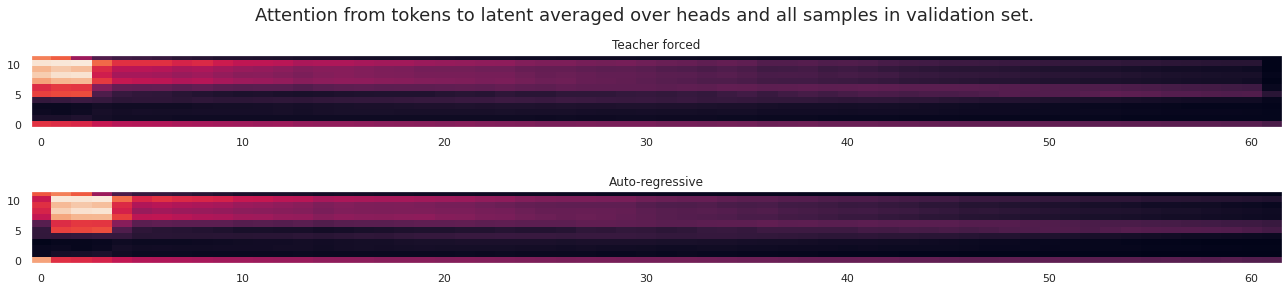

In [36]:
rcParams['axes.grid'] = False

teacher_att_to_latent_cat = torch.cat(teacher_att_to_latent, dim=0)
autoreg_att_to_latent_cat = torch.cat(autoreg_att_to_latent, dim=0)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18, 4))
axs[0].imshow(teacher_att_to_latent_cat.mean(dim=0).cpu().numpy(), origin='lower', aspect=0.3)
axs[0].set_title("Teacher forced")

axs[1].imshow(autoreg_att_to_latent_cat.mean(dim=0).cpu().numpy(), origin='lower', aspect=0.3)
axs[1].set_title("Auto-regressive")

plt.tight_layout()
plt.suptitle("Attention from tokens to latent averaged over heads and all samples in validation set.", fontsize=18, y=1.03)
plt.show()


# Ngrams overlap statistics

In [37]:
def ngrams_to_positions(ngrams):
    ngram_to_pos = {}
    for i, ngram in enumerate(ngrams):
        if ngram in ngram_to_pos:
            ngram_to_pos[ngram].append(i)
        else:
            ngram_to_pos[ngram] = [i]
    return ngram_to_pos

def find_ngrams(input_list, n):
    ngrams = list(zip(*[input_list[i:] for i in range(n)]))
    ngrams = [frozenset(ng) for ng in ngrams]
    return ngrams

def get_matching_ngram_stats(pred_list, target_list, n):
    pred_ngrams = find_ngrams(pred_list, n)
    target_ngrams = find_ngrams(target_list, n)
    target_ngrams_to_pos = ngrams_to_positions(target_ngrams)
    
    matching_pos = []
    for ngram in pred_ngrams:
        if ngram in target_ngrams_to_pos:
            matching_pos.extend(target_ngrams_to_pos[ngram])
    
    return matching_pos

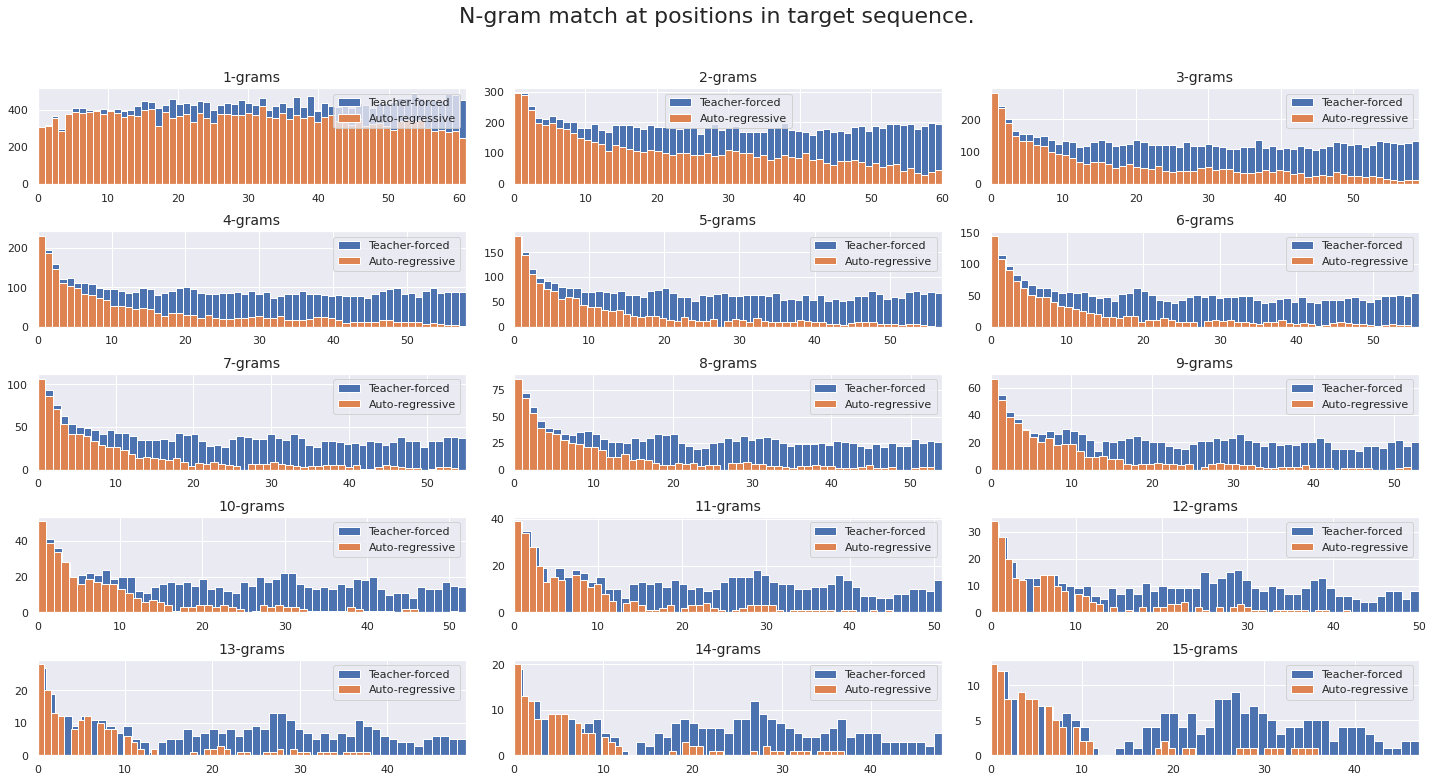

CPU times: user 13.8 s, sys: 440 ms, total: 14.2 s
Wall time: 14.2 s


In [38]:
%%time

rcParams['axes.grid'] = True

max_n_grams = 15
n_cols = 3
n_rows = int(np.ceil(max_n_grams/n_cols))

teacher_preds = np.concatenate(teacher_pred_ids_all, axis=0)
autoreg_preds = np.concatenate(autoreg_pred_ids_all, axis=0)
targets = np.concatenate(input_ids_all, axis=0)

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_rows*4, n_cols*3.5))

for n in range(1, max_n_grams+1):
    teacher_matching_pos, autoreg_matching_pos = [], []
    for teacher_sent, autoreg_sent, target_sent in zip(teacher_preds.tolist(), autoreg_preds.tolist(), targets.tolist()):        
        teacher_matching_pos += get_matching_ngram_stats(teacher_sent, target_sent, n)
        autoreg_matching_pos += get_matching_ngram_stats(autoreg_sent, target_sent, n)

    i = n - 1
    row = int(np.floor(i / n_cols))
    col = int(i % n_cols)
        
    axs[row, col].set_title(f"{n}-grams", fontsize=14)
    axs[row, col].hist(teacher_matching_pos, label='Teacher-forced', bins=62-n+1)
    axs[row, col].hist(autoreg_matching_pos, label='Auto-regressive', bins=62-n+1)
    axs[row, col].legend()
    axs[row, col].set_xlim(0, 61-n+1)

plt.suptitle("N-gram match at positions in target sequence.", fontsize=22, y=1.03)
plt.tight_layout()
plt.show()

## Exact match of tokens at exact positions over sequence length

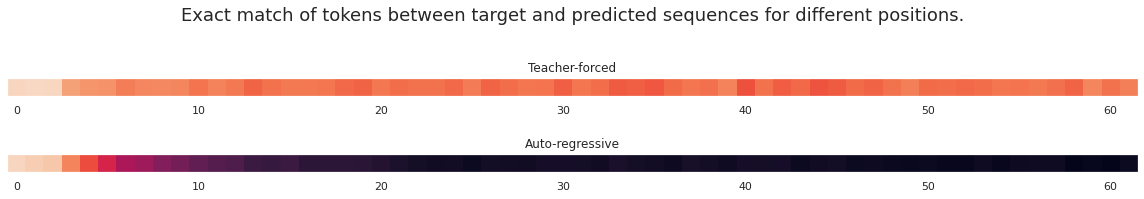

In [39]:
rcParams['axes.grid'] = False

teacher_correct_concat = np.concatenate(teacher_correct_all, axis=0)
autoreg_correct_concat = np.concatenate(autoreg_correct_all, axis=0)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 3))
axs[0].imshow(np.expand_dims(np.mean(teacher_correct_concat, axis=0), axis=0), vmax=1.0, vmin=0.0, origin='lower')
axs[0].get_yaxis().set_visible(False)
axs[0].set_title("Teacher-forced")

axs[1].imshow(np.expand_dims(np.mean(autoreg_correct_concat, axis=0), axis=0), vmax=1.0, vmin=0.0, origin='lower')
axs[1].set_title("Auto-regressive")
axs[1].get_yaxis().set_visible(False)

plt.suptitle("Exact match of tokens between target and predicted sequences for different positions.", fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
# %%time

# seq_positions_x = []
# layer_positions_y = []
# mean_attention_weights = []

# for batch_i, batch in enumerate(valid_loader):
#     print(f"{batch_i:5d} / {len(valid_loader):5d}", end='\r')
    
#     batch = transfer_batch_to_device(batch, device_name)
    
    
    
#     with torch.no_grad():
        
#         vae_output = vae_model.forward(batch["input_ids"], batch["attention_mask"], beta=1.0,
#                                        return_predictions=False,
#                                        return_attention_probs=True,
#                                        return_exact_match_acc=True,
#                                        objective='beta-vae', hinge_kl_loss_lambda=0.0)
        
#         # a is a tuple of length 12 (12 layers)
#         a = vae_output['attention_probs'] 

#         # stack all layers into one big tensor
#         a = torch.stack(a)

#         # batch, n_heads, n_layers, seq_len_query, seq_len_val
#         a = a.permute(1, 2, 0, 3, 4)
        
#         # For all in batch
#         batch_size = batch["input_ids"].shape[0]
#         for idx_batch in range(batch_size):
            
#             if batch_i == 0 and idx_batch == 0:
#                 print(45 * "-", f"IDX {idx_batch} IN BATCH", 45 * "-")
                
#                 print(tokenizer.decode(batch["input_ids"][0, :].cpu().numpy()))

#                 # Plot per head
#                 for head_i in range(12):
#                     # flip to have layer 0 at the bottom -> use flipud(m)
#                     a_head_i = a[idx_batch, head_i, :, :, 0].detach().cpu().numpy()

#                     plt.subplot(4, 3, head_i+1)
#                     plt.grid(False)
# #                     plt.axis('off')
#                     plt.title(f"Head {head_i+1}")
#                     plt.imshow(a_head_i, origin="lower")

#                 plt.tight_layout()
#                 plt.show()

#             # Average over heads
#             a_mean_heads = a[idx_batch, :, :, :, 0].mean(1).detach().cpu().numpy()
            
#             if batch_i == 0 and idx_batch == 0:
#                 plt.imshow(a_mean_heads, origin="lower")
# #                 plt.axis('off')
#                 plt.grid(False)
#                 plt.title("Average head attention from tokens to latent in memory")
#                 plt.show()
            
#             x = np.linspace(0, 63, 64)
#             y = np.linspace(0, 11, 12)
#             xv, yv = np.meshgrid(x, y)
            
#             seq_positions_x.append(xv)
#             layer_positions_y.append(yv)
#             mean_attention_weights.append(a_mean_heads)
    
# #     if batch_i == 500:
# #         break

In [ ]:
# # Stack the lists of matrices and flatten to get x, y and value vectors
# seq_positions_x_flat = np.concatenate(seq_positions_x).flatten()
# layer_positions_y_flat = np.concatenate(layer_positions_y).flatten()
# mean_attention_weights_flat = np.concatenate(mean_attention_weights).flatten()
# mean_attention_weights_times_position = (seq_positions_x_flat+1)*mean_attention_weights_flat

# df = pd.DataFrame({"seq_x": seq_positions_x_flat, 
#                    "layer_y":layer_positions_y_flat,
#                    "attention_weights": mean_attention_weights_flat,
#                    "attention_weights_times_position": mean_attention_weights_times_position})
# df

# Attention probabilties to latent

In [ ]:
# plt.imshow(np.stack(mean_attention_weights).mean(0), origin='lower')
# plt.colorbar()
# plt.title("Average (over heads and whole validation set) attention probability given to the latent vector in the decoder.")
# plt.grid(False)

In [ ]:
# plt.scatter(seq_positions_x_flat, mean_attention_weights_flat, alpha=0.01)
# plt.title("Attention probability to latent vector for different positions in the sequence.")
# plt.ylabel("Attention probability")
# plt.xlabel("Sequence position")
# plt.show()

In [ ]:
# # ax = sns.swarmplot(x="seq_x", y="attention_weights", data=df, color=".25") <-- takes forever
# fig, ax = plt.subplots(figsize=(20, 10))
# ax = sns.violinplot(ax=ax, x="seq_x", y="attention_weights", data=df) # cut = 0 , linewidth=0
# plt.title("Attention probability to latent vector for different positions in the sequence.")
# plt.ylabel("Attention probability")
# plt.xlabel("Sequence position")
# plt.show()

In [ ]:
# plt.scatter(seq_positions_x_flat, mean_attention_weights_times_position, alpha=0.05)
# plt.title("Attention probability times sequence length to latent vector for different positions in the sequence.")
# plt.ylabel("Attention probability x sequence length")
# plt.xlabel("Sequence position")
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 10))
# ax = sns.violinplot(ax=ax, x="seq_x", y="attention_weights_times_position", data=df) # cut = 0 , linewidth=0
# plt.title("Attention probability times sequence length to latent vector for different positions in the sequence.")
# plt.ylabel("Attention probability x sequence length")
# plt.xlabel("Sequence position")
# plt.show()

In [ ]:
# plt.scatter(layer_positions_y_flat, mean_attention_weights_flat, alpha=0.05)
# plt.title("Attention probability to latent vector for different layers in the model.")
# plt.ylabel("Attention probability")
# plt.xlabel("Layer")
# plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.violinplot(ax=ax, x="layer_y", y="attention_weights", data=df) # cut = 0
plt.title("Attention probability to latent vector for different layers in the model.")
plt.ylabel("Attention probability")
plt.xlabel("Layer")
plt.show()

In [ ]:
# Old code for trying semantic similarity for increasing sequence length
# Problems: slow & semantic similarity always seems high?

# nlp_model = spacy.load('en_core_web_md')

# def sent_sim_for_different_lenghts(sims, s1, s2):
#     """
#     Compare sentences semantically over different lengths.
#     """
    
#     s1_s = s1.split(" ")
#     s2_s = s2.split(" ")
#     max_len = min(len(s1_s), len(s2_s))
    
#     for i in range(0, max_len, 1):
#         print(f"{i:4d}", end="\r")
#         doc1 = nlp_model(" ".join(s1_s[i:i+10]))
#         doc2 = nlp_model(" ".join(s2_s[i:i+10]))
#         sim = doc1.similarity(doc2)
#         if i in sims:
#             sims[i].append(sim)
#         else:
#             sims[i] = [sim]
#     return sims

# from pylab import rcParams
# rcParams['figure.figsize'] = 20, 8
# rcParams['axes.grid'] = False

# ar = np.zeros((1, 64))

# for k, v in autoreg_sims_for_different_sent_lengths.items():
#     ar[0, k] = np.mean(v)

# tf = np.zeros((1, 64)) 

# for k, v in teacher_sims_for_different_sent_lengths.items():
#     tf[0, k] = np.mean(v)

# plt.imshow(ar)
# plt.colorbar()
# plt.show()

# plt.imshow(tf)
# plt.colorbar()
# plt.show()